<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/master/Unsupervised/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O "utils.py" "https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/master/utils.py"

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from utils import DataLoader
from utils import display_side_by_side as display_sbs
from utils import draw_corr_heatmap

random_state = 3
scaler = StandardScaler()


--2021-10-16 19:17:14--  https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8016 (7.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.83K  --.-KB/s    in 0s      

2021-10-16 19:17:14 (46.2 MB/s) - ‘utils.py’ saved [8016/8016]



In [2]:
#@markdown Corruption -- 高好 <br>
#@markdown Peace --------- 低好 <br>
#@markdown Legal ---------- 高好 <br>
#@markdown GDP Growth 高好 <br>
cr_df = DataLoader.load_data('country_risk_url')
display(cr_df.head())

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,39,1.867,3.822,3.403
1,Algeria,DZ,34,2.213,4.160,4.202
2,Argentina,AR,36,1.957,4.568,-2.298
3,Armenia,AM,33,2.218,4.126,0.208
4,Australia,AU,79,1.465,8.244,2.471


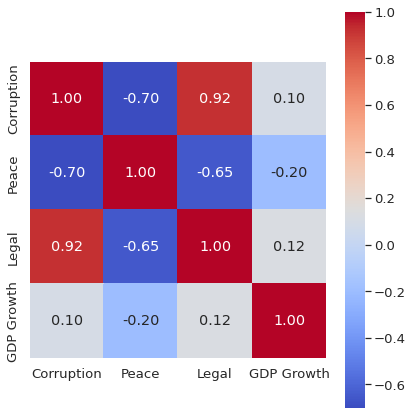

In [3]:
#@markdown 如果 feature 間存在 correlation 的話 <br> 
#@markdown 是不是會影響後續演算法的效果 <br>

numeric_f = cr_df.columns[2:6]
corr_matrix = cr_df[numeric_f].corr()
draw_corr_heatmap(corr_matrix, numeric_f)

# performance measurements

*   Inertia
>$Inertia=\sum_{j}\sum_{i} (d_{i} - m_{j})^2$, where $d_j \in ith$ cluster \\
> 對於 i 點，它屬於 j 群，則計算它到 j 群中心 差的平方 \\
> idea：每群所擁有的點，盡可能 overall 接近中心
*   average silhouette score = $\frac{1}{N}\sum_i s(i)$
>$s(i)=\frac{b(i) - a(i)}{max(b(i), a(i))}$, $s(i) \in [-1, 1]$ \\
> 對於 i 點，它屬於 j 群 \\
> $ a(i) $ 計算除 j 群之外，與所有其他群的群中心的距離，並保留下最近的距離值 \\
> $ b(i) $ 計算和 j 群的群中心的距離值 \\
> idea： i 點歸類為 j 群是不是一個最好的選擇，若是了，那好的程度又是多少

# k-Means

*   Choosing k \\
    可以使用上述兩種 performance measurement 的方式選擇 k (群數)

In [4]:
# 使用數值的特徵 -> 相對於後續實驗為 original
orig_input = cr_df[numeric_f]

scaled_input = scaler.fit_transform(orig_input)

In [5]:
# 可以嘗試自行解讀三個群中心，各自合理的標籤應該是什麼
km = KMeans(n_clusters=3, random_state=random_state).fit(orig_input)
km_cen_df = pd.DataFrame(km.cluster_centers_,
                         columns=orig_input.columns,
                         index=['moderate', 'high', 'low'])

km_scaled = KMeans(n_clusters=3, random_state=random_state).fit(scaled_input)
km_cen_df_scaled = pd.DataFrame(km_scaled.cluster_centers_,
                                columns=orig_input.columns,
                                index=['high', 'low', 'moderate'])

avg_sil = silhouette_score(orig_input, km.labels_)
scaled_avg_sil = silhouette_score(scaled_input, km_scaled.labels_)

display_sbs([km_cen_df, km_cen_df_scaled], 
            ['原始資料', '標準化資料'],
            [f'score: {avg_sil:.3f}', f'score: {scaled_avg_sil:.3f}'])

high_risk = cr_df[km.labels_==1][['Country']]
scaled_high_risk = cr_df[km_scaled.labels_==0][['Country']]
print()

print("original 認為是高風險 但 scaled 不認為：")
print(np.setdiff1d(high_risk.values, scaled_high_risk.values))
print()

print("scaled 認為是高風險 但 original 不認為：")
print(np.setdiff1d(scaled_high_risk.values, high_risk.values))

原始資料 標準化資料 
 
 
 
 Corruption 
 Peace 
 Legal 
 GDP Growth 
 
 
 
 
 moderate 
 53.500000 
 1.830441 
 6.119735 
 2.793088 
 
 
 high 
 32.014925 
 2.245000 
 4.566194 
 2.221000 
 
 
 low 
 79.857143 
 1.514524 
 8.050238 
 2.175286 
 
 
 
 
 
 
 Corruption 
 Peace 
 Legal 
 GDP Growth 
 
 
 
 
 high 
 -1.027467 
 1.352217 
 -1.059033 
 -1.719983 
 
 
 low 
 1.231352 
 -0.979187 
 1.165956 
 0.010270 
 
 
 moderate 
 -0.479569 
 0.263309 
 -0.435100 
 0.373518 
 
 
 score: 0.557 score: 0.407


original 認為是高風險 但 scaled 不認為：
['Albania' 'Algeria' 'Armenia' 'Bangladesh' 'Benin' 'Bolivia'
 'Bosnia and Herzegovina' 'Bulgaria' 'Cameroon' 'China' 'Colombia'
 'Dominican Republic' 'Egypt' 'El Salvador' 'Ethiopia' 'Gabon' 'Guatemala'
 'Honduras' 'India' 'Indonesia' 'Iran' 'Jamaica' 'Kazakhstan' 'Kenya'
 'Kuwait' 'Liberia' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Mexico'
 'Moldova' 'Morocco' 'Mozambique' 'Nepal' 'Nicaragua' 'Pakistan' 'Panama'
 'Paraguay' 'Peru' 'Philippines' 'Serbia' 'Sierra Leone' 'Sri Lanka'
 'Tanzania' 'Thailand' 'The FYR of Macedonia' 'Tunisia' 'Turkey' 'Uganda'
 'Vietnam' 'Zambia']

scaled 認為是高風險 但 original 不認為：
[]


kmeans 標準化後分數反而降低？ 但是在 GDP Growth 上不一致 （高風險國家應該要最低）

In [6]:
# 額外的一點 work，把每筆資料依序標上分群後推論分析出來的標籤，以便後續使用
category = {0: "high", 1: "low", 2: "moderate"}
km_scaled_str_lbl = np.array(list(map(lambda n: category[n], km_scaled.labels_)))
km_scaled_str_lbl[:5]

array(['moderate', 'moderate', 'high', 'moderate', 'low'], dtype='<U8')

In [7]:
# 去掉 Corruption（與 Legal 高度相關）
three = cr_df[numeric_f[1:]]

scaled_three = scaler.fit_transform(three)

In [8]:
km_scaled_three = KMeans(n_clusters=3, random_state=random_state).fit(scaled_three)
km_cen_df_scaled_three = pd.DataFrame(km_scaled_three.cluster_centers_,
                                      columns=three.columns,
                                      index=['high', 'low', 'moderate'])
scaled_three_avg_sil = silhouette_score(scaled_three, km_scaled_three.labels_)

display_sbs([km_cen_df_scaled, km_cen_df_scaled_three],
            ['4 特徵標準化', '3 特徵標準化'],
            [f'score: {scaled_avg_sil:.3f}', f'score: {scaled_three_avg_sil:.3f}'])

four_high_risk = cr_df[km_scaled.labels_==0][['Country']]
three_high_risk = cr_df[km_scaled_three.labels_==0][['Country']]
print()

print("4 認為是高風險 但 3 不認為：")
print(np.setdiff1d(four_high_risk.values, three_high_risk.values))
print()

print("3 認為是高風險 但 4 不認為：")
print(np.setdiff1d(three_high_risk.values, four_high_risk.values))

4 特徵標準化 3 特徵標準化 
 
 
 
 Corruption 
 Peace 
 Legal 
 GDP Growth 
 
 
 
 
 high 
 -1.027467 
 1.352217 
 -1.059033 
 -1.719983 
 
 
 low 
 1.231352 
 -0.979187 
 1.165956 
 0.010270 
 
 
 moderate 
 -0.479569 
 0.263309 
 -0.435100 
 0.373518 
 
 
 
 
 
 
 Peace 
 Legal 
 GDP Growth 
 
 
 
 
 high 
 1.397830 
 -1.046003 
 -1.801892 
 
 
 low 
 -0.931933 
 1.171223 
 -0.014518 
 
 
 moderate 
 0.260407 
 -0.473601 
 0.379518 
 
 
 score: 0.407 score: 0.387


4 認為是高風險 但 3 不認為：
['Zimbabwe']

3 認為是高風險 但 4 不認為：
[]


# The Curse of Dimensionality

如果資料的維度越高，空間的體積越大 \\
原先的資料量顯得稀疏

In [9]:
a = np.array([1] * 3)
b = np.array([2] * 3)
d_ab = np.sqrt(((a-b)**2).sum())
print(f'a, b 兩點存在 3 維空間中 \n a: {a}, b: {b}')
print(f'd(a, b) = {d_ab:.3f}')
print()

x = np.array([1] * 10)
y = np.array([2] * 10)
d_xy = np.sqrt(((x-y)**2)).sum()
print(f'x, y 兩點存在 10 維空間中 \n x: {x}, y: {y}')
print(f'd(x, y) = {d_xy:.3f}')
print()

norm_a = np.sqrt((a**2).sum())
norm_b = np.sqrt((b**2).sum())
norm_x = np.sqrt((x**2).sum())
norm_y = np.sqrt((y**2).sum())

# cosine similarity
simi_ab = (a@b)/(norm_a * norm_b)
simi_xy = (x@y)/(norm_x * norm_y)

print(f'cosine_similarity(a, b) = {simi_ab:.8f}')
print(f'cosine_similarity(x, y) = {simi_xy:.8f}')
print(f'1 - cosine_similarity(a, b) = {1-simi_ab:.8f}')
print(f'1 - cosine_similarity(x, y) = {1-simi_xy:.8f}')

a, b 兩點存在 3 維空間中 
 a: [1 1 1], b: [2 2 2]
d(a, b) = 1.732

x, y 兩點存在 10 維空間中 
 x: [1 1 1 1 1 1 1 1 1 1], y: [2 2 2 2 2 2 2 2 2 2]
d(x, y) = 10.000

cosine_similarity(a, b) = 1.00000000
cosine_similarity(x, y) = 1.00000000
1 - cosine_similarity(a, b) = -0.00000000
1 - cosine_similarity(x, y) = 0.00000000


*   向量同向 -> (1 - cosine_similarity) 表達距離為 0
*   向量垂直 -> (1 - cosine_similarity) 表達距離為 1
*   向量反向 -> (1 - cosine_similarity) 表達距離為 2

距離最近為 0，最遠為 2，無論維度是多少

# PCA

>什麼樣的向量$w$，可以使得所有data point投影上去後訊息損失(information loss)最低 <br>
lower information loss -> higher variance kept<br>

>given任意n維的vector，皆能被某個basis $W$ (n個components, orthogonal to each other)的線性組合唯一表示(zero loss) <br> 如果只用幾個component，就會有loss <br>
線性組合的 scalars 怎麼找？ -> 投影長 = ${\lVert x \rVert}cos{\theta}, $ where ${\theta}$ 為 x 和 w 的夾角 <br>
under constraint： <br>
>>${\lVert w_{n} \rVert} = 1$<br>

>投影長 = $scalar_{n,i} = w_{n} \cdot x_{i}$ <br>
先找一個component就好，使得variance最大，objective funciton？<br>
$Objective$ = 投影長的variance = $\sum_{i} (w_{1} \cdot x_{i} - w_{1} \cdot \bar x)^2$
......<br>...... $w_{1}$ 是 Cov(x) 的最大 eigenvalue(其值為所求的variance) 對應的 eigenvector <br> 這樣的 $w_{1}$(the most dominant pattern) 可以 maximize $Objective$

>那想要找到一組basis呢？ <br>
under constraints：<br>
    >>${\lVert w_{2} \rVert} = 1$<br>
    >>$w_{2} \cdot w_{1} = 0$<br>

>$Objective = \sum_{i} (w_{2} \cdot x_{i} - w_{2} \cdot \bar x)^2$ ......<br>...... $w_{2}$ 是 Cov(x) 第二大 eigenvalue(其值為所求的variance) 對應的 eigenvector <br> 這樣的 $w_{2}$ 可以 maximize $Objective$

> let $W = [w_{1} w_{2} ... w_{k}]$ form a basis, $W^{T}$.shape = (n_components=k, n_features)<br>
let $Z = W^{T}X$, <br>=> X.shape = (n_features, n_samples)<br> => Cov(X).shape = (n_features, n_features) = W.shape = (k, k)<br>
=> Z.shape = (n_components=k, n_samples)<br> => 每個 sample 都有 k個 scalars 用來線性組合回原本的 data x 

>也可以想成 $Z^T = X^TW$<br>

z 是線性組合的 scalar，也是投影長
<br>for the component 1, $Z_{1, m}$ 的 variance 代表投影到這個 component 所保留的 variance (Objective, 其值為 Cov(x) 的 eigenvalues)
<br> for the sample 1, $Z_{n, 1}$ 表示此 data point 轉換到新的 basis $W$ 上的座標


# Singular Value Decomposition

$M = U \sum V^T$ (for any matrix M) <br>
$Z^TW^T = X^T = U \sum V^T$ <br>

$V^T=W^T, Z^T=U\sum$ <br>
$XX^T = V \sum^2V^T => XX^TV = V \sum^2 => V = W$ (economy版的svd, $\sum$ 是 diagonal matrix)<br>
$X^TX = U \sum^2U^T => XX^TU = U \sum^2$ => U is consist of the eigenvectors of $X^TX$ (並不是 samples 間的 covariance matrix)<br>

In [10]:
orig_input = cr_df[numeric_f]

# 標準化對於 PCA 很重要
X = StandardScaler().fit_transform(orig_input)
print(X.shape)  # X^T

(122, 4)


In [11]:
# Cov(X) = X^T @ X  (n_features x n_features)
CovX = X.T @ X
eigvals, eigvecs = np.linalg.eig(CovX)

# 負的由小排到大 正的由大排到小
desc_eigvals_arg = np.argsort(-eigvals)
eigvals, eigvecs = eigvals[desc_eigvals_arg], eigvecs[:, desc_eigvals_arg]

cols = ['component1', 'component2', 'component3', 'component4']
index = ['feature1', 'feature2', 'feature3', 'feature4']

df_eig = pd.DataFrame(eigvecs, columns=cols, index=index)

U, C, VT = np.linalg.svd(X)
df_svd = pd.DataFrame(VT.T, columns=cols, index=index)

display_sbs([df_eig, df_svd], ['Cov Matrix 解', 'SVD 解'])


print("左右一致？", np.allclose(df_eig, df_svd))
print("Q: 第 4 個 component 差一個負號，why?")
print("A: 投影值也差了一個負號")
print((X@eigvecs)[:4, -1])
print((U[:, :4]@np.diag(C))[:4, -1])
print("explained variance :", eigvals)
print("singular value ^ 2: ", C**2)

Cov Matrix 解 SVD 解 
 
 
 
 component1 
 component2 
 component3 
 component4 
 
 
 
 
 feature1 
 0.594089 
 -0.155184 
 0.291640 
 -0.733431 
 
 
 feature2 
 -0.530424 
 -0.039876 
 0.842391 
 -0.086246 
 
 
 feature3 
 0.585023 
 -0.134562 
 0.430976 
 0.673721 
 
 
 feature4 
 0.153154 
 0.977865 
 0.139939 
 -0.027201 
 
 
 
 
 
 
 component1 
 component2 
 component3 
 component4 
 
 
 
 
 feature1 
 0.594089 
 -0.155184 
 0.291640 
 0.733431 
 
 
 feature2 
 -0.530424 
 -0.039876 
 0.842391 
 0.086246 
 
 
 feature3 
 0.585023 
 -0.134562 
 0.430976 
 -0.673721 
 
 
 feature4 
 0.153154 
 0.977865 
 0.139939 
 0.027201

左右一致？ False
Q: 第 4 個 component 差一個負號，why?
A: 投影值也差了一個負號
[-0.51174702 -0.23913034 -0.02628702 -0.18340259]
[0.51174702 0.23913034 0.02628702 0.18340259]
explained variance : [312.48251428 118.93717519  47.67032408   8.90998645]
singular value ^ 2:  [312.48251428 118.93717519  47.67032408   8.90998645]


與 library 給出的結果是否契合、如何對應

In [12]:
pca = PCA(n_components=4)
pca.fit(X)
# Z 為 投影長、線性組合係數
Z = pca.transform(X)

# lib 與上面方法結果一致
print(np.allclose(X, Z @ pca.components_))
print(np.allclose(X, X @ eigvecs @ eigvecs.T))
print(np.allclose(X, U[:, :4] @ np.diag(C) @ VT))

True
True
True


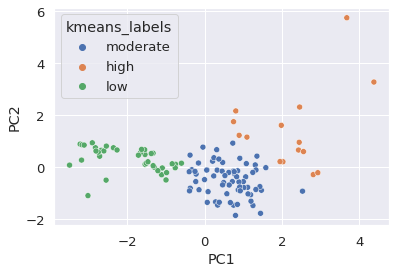

,Corruption,Peace,Legal,GDP Growth
PC1,-0.594089,0.530424,-0.585023,-0.153154
PC2,0.155184,0.039876,0.134562,-0.977865


In [13]:
Z_2components = Z[:, :2]
new_coord = pd.DataFrame(Z_2components, columns=['PC1', 'PC2'], index=cr_df['Country'])
new_coord_with_km_lbl = new_coord.copy()
new_coord_with_km_lbl.insert(2, 'kmeans_labels', km_scaled_str_lbl)
sns.scatterplot(x='PC1', y='PC2', data=new_coord_with_km_lbl, hue='kmeans_labels')
plt.show()

display(pd.DataFrame(pca.components_[:2], index=['PC1', 'PC2'], columns=orig_input.columns))


挑一些邊邊、較極端的例子看看

In [14]:
display_sbs([new_coord[(new_coord.PC1 > 4) | (new_coord.PC2 > 5)].round(2),
             new_coord[(new_coord.PC1 < -2) & (new_coord.PC2 < 0)].round(2),
             new_coord[(new_coord.PC2 < -1.7)].round(2),
             new_coord[new_coord.PC1 < -3.2].round(2)])

,PC1,PC2
Country,,
Venezuela,3.67,5.75
Yemen,4.38,3.28
,PC1,PC2
Country,,
Iceland,-3.01,-1.09
Ireland,-2.55,-0.49
,PC1,PC2
Country,,
Bangladesh,1.44,-1.77


用 explained variance ratio 來加權和係數，得到一個估計的風險分數

In [15]:
of_interest_countries = ['Taiwan', 'China', 'United Kingdom',
                         'United States','Italy', 'Spain',
                         'South Africa', 'Russia']

risk_measurement = (new_coord @ pca.explained_variance_ratio_[:2]).sort_values(ascending=False)
risk_score = (pd.DataFrame(MinMaxScaler((0, 100)).fit_transform(risk_measurement.values.reshape(-1, 1)),
                           index=risk_measurement.index,
                           columns=['risk score'])).round(1)
sorted_idx = risk_score.loc[of_interest_countries].squeeze().sort_values(ascending=False).index
display_sbs([risk_score.iloc[:5],
             risk_score.iloc[-5:],
             risk_score.loc[sorted_idx],
             cr_df.set_index('Country').loc[sorted_idx, orig_input.columns]])

,risk score
Country,
Venezuela,100.0
Yemen,97.4
Chad,72.9
Ukraine,67.6
Nigeria,67.2
,risk score
Country,
Finland,6.7
Denmark,6.2


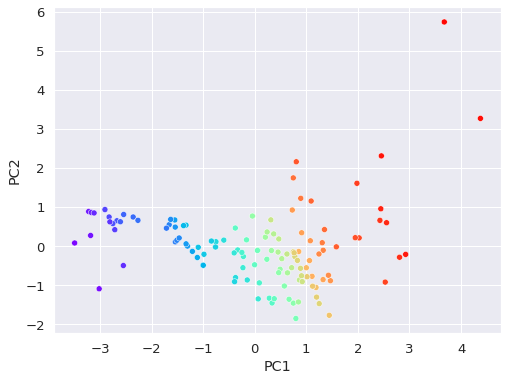

In [16]:
plt.figure(figsize=(8, 6))
palette = sns.color_palette('rainbow', n_colors=risk_score['risk score'].unique().size)

new_coord = pd.DataFrame(Z_2components, columns=['PC1', 'PC2'], index=cr_df['Country'])
new_coord_with_risk_score = new_coord.copy()
new_coord_with_risk_score.insert(2, 'risk score', risk_score['risk score'])
sns.scatterplot(x='PC1', y='PC2', data=new_coord_with_risk_score,
                hue='risk score', palette=palette, legend=False)
plt.show()

轉換到一個新的座標系統，PCA(SVD)會找到唯一一個特別的座標系統，將原本的資料換成新的basis的線性組合(matrix factorization)<br>
每個維度依序capture最多的資訊，維度表示特徵(如同原本每個feature也是一個維度，做feature selection就是只認為其中幾個feature有用，什麼叫有用？如果over all samples 該 feature standardized 後的值都很近，就表示沒有參考價值，因為information gain很低)，換了新的basis後每個 component 代表一個 new feature，需重新思考其意義 <br>
 
單取Z的這些投影長，如只取2個維度(Z') => 降維至平面 <br>
Z' 和 basis' 線性組合 => 在原本n維空間中，在此 basis' span 出一個平面上<br>
>Eckart-Young Theorem<br>
${\lVert x- \tilde x \rVert}_{F}$ is minimum under rank($\tilde x$)=2<br>
$\tilde x$ 能最佳近似 $x$ if $\tilde x$ = Z' @ basis'


In [17]:
x_tilde = Z_2components @ pca.components_[:2]
min_recon_error = np.sqrt(((orig_input.values - x_tilde)**2).sum())
print(f'{min_recon_error:.2f}')

553.71


# agglomerative clustering

1. 每一個 data point 自己一個 cluster
2. 找最近的兩個 clusters 聚為一個 cluster <br>
   cluster間的遠近定義？ 多種可能，以下舉兩個例子 <br>
   average : $dist(C_i, C_j) = \sum_{a \in C_i, b \in C_j}\frac{d(a, b)}{|C_{i}||C_{j}|}$ <br>
   ward : $dist(C_i, C_j) = \sum_{a \in (C_i \cup C_j)} ||a - \mu_{C_i \cup C_j}||^2$
3. 重複 2 直到所有 point 聚為一群



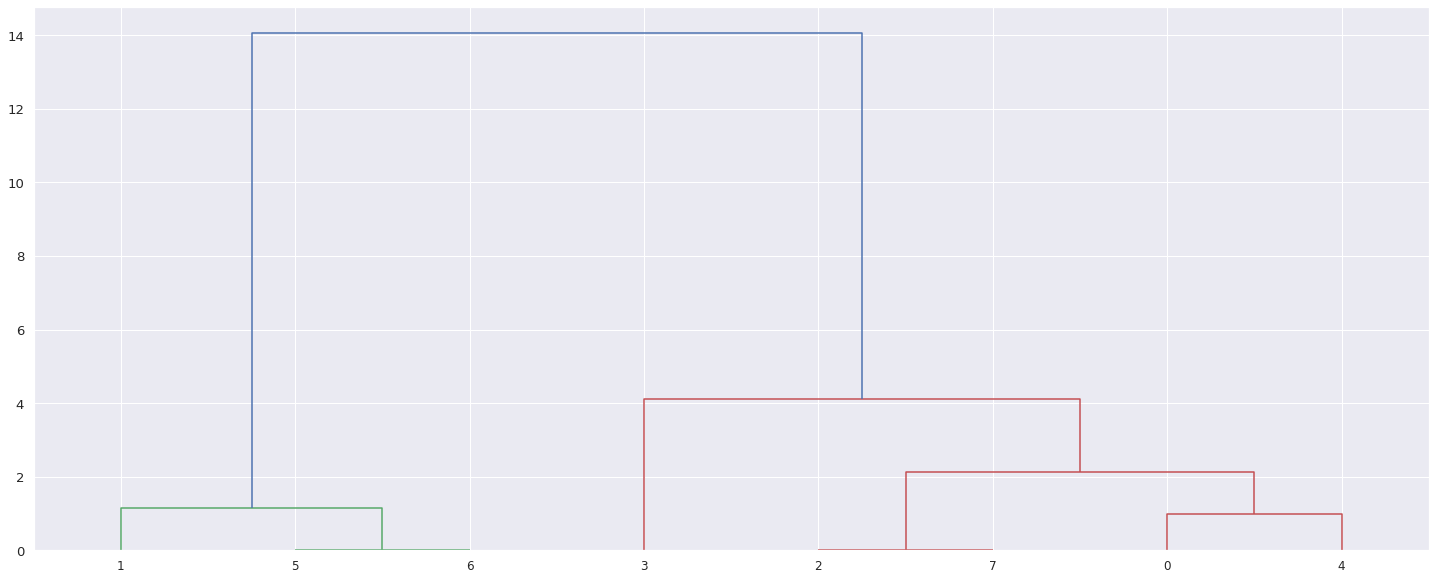

,群 i,群 j,ward距離,群內個數
8,5,6,0.00,2
9,2,7,0.00,2
10,0,4,1.00,2
11,1,8,1.15,3
12,9,10,2.12,4
13,3,12,4.11,5
14,11,13,14.07,8


In [18]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(X, 'ward')
df_Z = pd.DataFrame(Z, columns=['群 i', '群 j', 'ward距離', '群內個數'], 
                    index=range(len(X), len(X)+len(Z)))
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

display(df_Z.round(2).astype({'群 i': int, '群 j': int, '群內個數': int}))


1.   檢視一下 agg 分出來的效果是否合理
2.   比較 agg 和 kmeans 結果



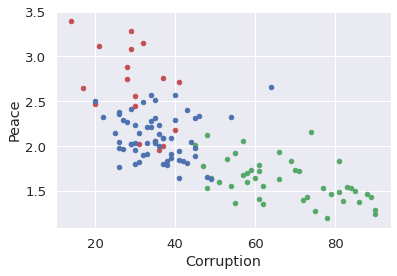


agg 認為是高風險 但 kmeans 不認為：
['Colombia' 'Liberia' 'Mexico' 'Pakistan' 'Turkey']

kmeans 認為是高風險 但 agg 不認為：
['Burundi']


In [19]:
three = cr_df[['Peace', 'Legal', 'GDP Growth']]
scaled_three = scaler.fit_transform(three)

agg = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(scaled_input)
km_scaled_three = KMeans(n_clusters=3, random_state=random_state).fit(scaled_three)

ax = plt.gca()
cr_df[agg.labels_==0].plot.scatter(x='Corruption', y='Peace', color='r', ax=ax)
cr_df[agg.labels_==1].plot.scatter(x='Corruption', y='Peace', color='g', ax=ax)
cr_df[agg.labels_==2].plot.scatter(x='Corruption', y='Peace', color='b', ax=ax)
plt.show()

# agg 認為高風險的國家
agg_high_risk = cr_df[agg.labels_==0][['Country']]
# kmeans 認為高風險的國家
km_high_risk_lbl = np.argmax(km_scaled_three.cluster_centers_[:, 0])
km_high_risk = cr_df[km_scaled_three.labels_==km_high_risk_lbl][['Country']]
print()

print("agg 認為是高風險 但 kmeans 不認為：")
print(np.setdiff1d(agg_high_risk.values, km_high_risk.values))
print()

print("kmeans 認為是高風險 但 agg 不認為：")
print(np.setdiff1d(km_high_risk.values, agg_high_risk.values))

嘗試不同的 linkage，看看結果

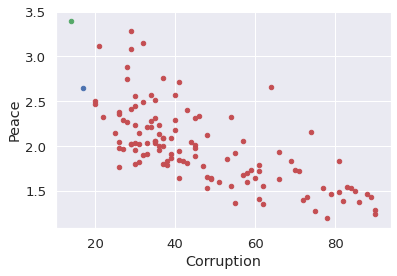


下表兩列依序為 藍點 綠點


,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
117,Venezuela,VE,17,2.651,3.000,-18.000
119,Yemen,YE,14,3.399,2.728,-9.779


In [20]:
agg = AgglomerativeClustering(n_clusters=3, linkage='average').fit(scaled_input)

ax = plt.gca()
cr_df[agg.labels_==0].plot.scatter(x='Corruption', y='Peace', color='r', ax=ax)
cr_df[agg.labels_==1].plot.scatter(x='Corruption', y='Peace', color='g', ax=ax)
cr_df[agg.labels_==2].plot.scatter(x='Corruption', y='Peace', color='b', ax=ax)
plt.show()

print()
print("下表兩列依序為 藍點 綠點")
display(cr_df[(agg.labels_==1) | (agg.labels_==2)])

# distribution-based clustering
數學推導待補

EM step: find $a_k, \mu_k, \sum_k$ s.t. Objective is approximately maximized

E step: cal $w_j(x_i)$ given $\mu_j, \sum_j, a_j, \forall j $ <br>

M step: 對 $L^{t+1}$ 的 $lower bound$ 分別對參數做偏微分=0
* $a_k^{t+1} = \frac{n_k^t}{n}, n_k^t = \sum_{i=1}^n w_k^t(x_i)$ <br><br>
* $\mu_k^{t+1} = \frac{1}{n_k^t}\sum_{i=1}^n w_k^t(x_i)x_i$ <br><br>
* $\sum_k^{t+1} = \frac{1}{n_k^t}\sum_{i=1}^n\sum_{k=1}^K w_k^t(x_i)(x_i - \mu_k^{t+1})(x_i - \mu_k^{t+1})^T$ <br><br>

以下為其應用例子

In [21]:
url = 'https://api.finmindtrade.com/api/v3/data?dataset={}&stock_id={}&date={}'
target = {
    'USStockPrice': ['^GSPC', '^DJI', '^IXIC', 'Adj_Close'],
    # 'TaiwanStockPrice': ['TAIEX', 'close']  不是 adjusted 暫不使用
}

index_data = {}

for t in target:
    for n in target[t][:-1]:
        data = requests.get(url.format(t, n, '2012-01-01')).json()
        # 取 adj close series
        index_data[n] = pd.DataFrame(data['data']).set_index('date')[target[t][-1]]
    index_df = pd.DataFrame(index_data).ffill().copy()
index_return_df = index_df.pct_change().dropna()*100
index_return_df.head(3)

,^GSPC,^DJI,^IXIC
date,,,
2012-01-04,0.018793,0.169713,-0.013591
2012-01-05,0.294371,-0.021903,0.811823
2012-01-06,-0.253696,-0.449270,0.163304


列出三組 gaussian dist. 的參數，由熊市排到牛市

In [22]:
x_train = index_return_df.iloc[:-252, :]
x_test = index_return_df.iloc[-252:, :]

mixture_model = GaussianMixture(n_components=3, random_state=random_state)
mixture_model.fit(x_train)

sorted_idx = np.argsort(mixture_model.means_.sum(axis=1))
cluster_params = {"means": mixture_model.means_[sorted_idx],
                  "vars": (np.linalg.det(mixture_model.covariances_[sorted_idx])**0.5)}
cluster_means = pd.DataFrame(cluster_params['means'],
                             index=['bear', 'bumpy', 'bull'],
                             columns=index_data.keys()).round(4)
cluster_vars = pd.DataFrame(cluster_params['vars'],
                            index=['bear', 'bumpy', 'bull'],
                            columns=['sqrt(det(cov_mat))']).round(4)
display_sbs([cluster_means, cluster_vars], ['高斯mu', '震盪程度'])

高斯mu 震盪程度 
 
 
 
 ^GSPC 
 ^DJI 
 ^IXIC 
 
 
 
 
 bear 
 -0.4863 
 -0.4431 
 -0.5639 
 
 
 bumpy 
 0.0728 
 0.0719 
 0.0533 
 
 
 bull 
 0.0907 
 0.0738 
 0.1524 
 
 
 
 
 
 
 sqrt(det(cov_mat)) 
 
 
 
 
 bear 
 0.8723 
 
 
 bumpy 
 0.1003 
 
 
 bull 
 0.0152

以參數預測 test_set 牛熊市機率

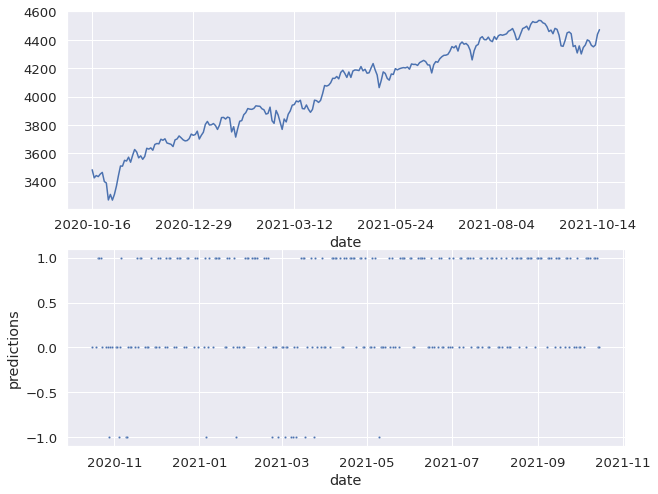

In [23]:
predictions = mixture_model.predict(x_test)
predictions_df = pd.DataFrame(predictions, index=x_test.index, columns=['predictions']).reset_index()
predictions_df['date'] = pd.to_datetime(predictions_df['date'])
predictions_df = predictions_df.replace({'predictions': {i: j for i, j in zip(sorted_idx, [-1, 0, 1])}})

_, axes = plt.subplots(2, 1, figsize=(10, 8))
index_df.iloc[-252:, :]['^GSPC'].plot(ax=axes[0])
sns.scatterplot(x='date', y='predictions', data=predictions_df, s=5, ax=axes[1])
plt.show()

牛熊市機率乘上 label -1, 0, 1，預測一個綜合的機率值 \\
再 rolling mean 做為一天的預測機率 -> 歸類

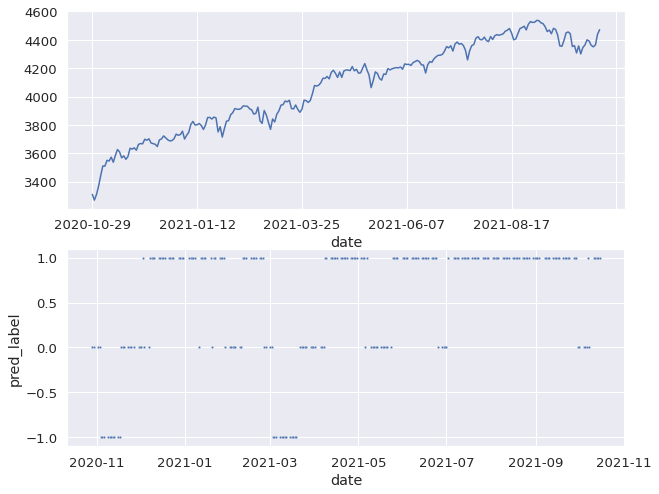

In [24]:
window = 10
pred_weighted_by_proba = mixture_model.predict_proba(x_test)[:, sorted_idx] @ np.array([-1, 0, 1])
pred_weighted_by_proba_df = pd.DataFrame(pred_weighted_by_proba,
                                         index=x_test.index,
                                         columns=['pred_weighted_by_proba']).reset_index()
pred_weighted_by_proba_df['date'] = pd.to_datetime(pred_weighted_by_proba_df['date'])
rolling_pred = pred_weighted_by_proba_df.set_index('date')\
                                        .rolling(window).mean()\
                                        .dropna().reset_index()
rolling_pred['pred_label'] = pd.cut(rolling_pred['pred_weighted_by_proba'], bins=3, labels=[-1., 0., 1.])
rolling_pred = rolling_pred.astype({"pred_label": np.float64})

_, axes = plt.subplots(2, 1, figsize=(10, 8))
index_df.iloc[-252+window-1:, :]['^GSPC'].plot(ax=axes[0])
sns.scatterplot(x='date', y='pred_label', data=rolling_pred, s=5, ax=axes[1])
plt.show()

# Density-Based Clustering

given MinPts(m), epsilon ($\epsilon$)

MinPts(m): 半徑 $\epsilon$ 圓內點數量 threshold

* core points: <br>
    $|N_\epsilon(q)| \geq m$

* border points: <br>
    $|N_\epsilon(p)| < m$ <br>
    $p \in N_\epsilon(q), $ q is a core point

* noise: <br>
    neither of the above
----------------------
1. mark all points

2. ignore noise points

3. $\forall$ core points $c_k,$<br>
   $\forall$ core points $c_j, j \neq k$<br>
   if $dist(c_j, c_k) < \epsilon$ : form_a_group($c_j, c_k$)

4. $\forall$ border points $c_b$ <br>
   $\forall$ core points $c_k$ <br>
   if $dist(c_b, c_k) < \epsilon$ : form_a_group($c_b, c_k$)

Q: 如果有個 border point, 對應於兩個核心點, 但那兩個核心點又不同群, 怎麼歸類？ <br>
A: 誰先判斷到就歸哪類 => not stable

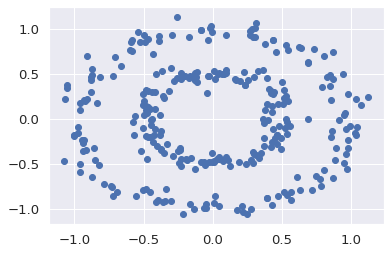

In [25]:
circles, c_labels = make_circles(n_samples=300, noise=.07,
                                 factor=.5, random_state=random_state)
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()

In [26]:
def get_label_color_mapping(model, X):
    model.fit(X)
    labels = model.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    return zip(unique_labels, colors)

db = DBSCAN(eps=.2)
km = KMeans(n_clusters=2)
db_mapping = get_label_color_mapping(db, circles)
km_mapping = get_label_color_mapping(km, circles)

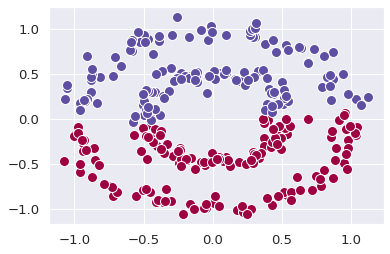

In [27]:
for k, col in km_mapping:
    class_member_mask = (km.labels_ == k)
    xy = circles[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=tuple(col), markeredgecolor='w', markersize=10)

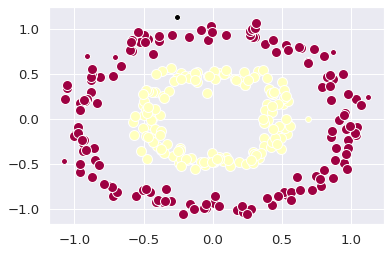

In [28]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
for k, col in db_mapping:
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (db.labels_ == k)
    xy = circles[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor=tuple(col), markeredgecolor='w', markersize=10)

    xy = circles[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=tuple(col), markeredgecolor='w', markersize=6)